# Assignment 1

## Topological Data Analysis - DATA70302

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
edu_df = pd.read_excel('/Users/alexander/Documents/MSc Data Science/S2/Topological Data Analysis/A1/data/Highest level of qual_nomis_2025_02_23_161034.xlsx')
edu_df.head()

,ward_name,lad,total,%,no_qual_num,no_qual_num%,level1_num,level1_num%,level2_num,level2_num%,apprenticenship_num,apprenticenship%,level3_num,level3_num%,level4_num,level4_num%,other_number,other%
0,Astley Bridge,E05000650,11398,100,1999,17.5,1171,10.3,1749,15.3,703,6.2,2037,17.9,3502,30.7,237,2.1
1,Bradshaw,E05000651,9455,100,1599,16.9,924,9.8,1197,12.7,724,7.7,1691,17.9,3075,32.5,245,2.6
2,Breightmet,E05000652,11218,100,2903,25.9,1327,11.8,1704,15.2,872,7.8,1830,16.3,2269,20.2,313,2.8
3,Bromley Cross,E05000653,11347,100,1368,12.1,928,8.2,1519,13.4,739,6.5,2054,18.1,4521,39.8,218,1.9
4,Crompton (Bolton),E05000654,13336,100,3658,27.4,1539,11.5,1860,13.9,627,4.7,2028,15.2,3216,24.1,408,3.1


### Gini Education Coefficient

In [41]:
# Define the mapping from the DataFrame's column names to years of schooling
score_map = {
    'no_qual_num': 0,
    'level1_num': 5,
    'level2_num': 10,
    'apprenticenship_num': 12,
    'level3_num': 13,
    'level4_num': 16
}

In [42]:
# Building the function:
def education_gini(row, score_map):
    total = row['total']
    # Check to avoid division by zero
    if total == 0:
        return 0
    
    # Compute the proportion for each category (pᵢ)
    proportions = {col: row[col] / total for col in score_map}
    
    # Compute the mean years of schooling (μ)
    mu = sum(proportions[col] * score_map[col] for col in score_map)
    
    # Avoid division by zero in case μ is 0
    if mu == 0:
        return 0
    
    # Compute the numerator: sum over all pairs i, j of pᵢ * pⱼ * |rᵢ - rⱼ|
    numerator = sum(proportions[i] * proportions[j] * abs(score_map[i] - score_map[j])
                    for i in score_map for j in score_map)
    
    # Return the Gini index as defined
    gini = numerator / (2 * mu)
    return gini

In [43]:
# Apply the function row-wise to calculate the Gini education index
edu_df['gini_education_index'] = edu_df.apply(lambda row: education_gini(row, score_map), axis=1)

# Display a sample of the results
print(edu_df[['ward_name','lad', 'gini_education_index']].head())

           ward_name        lad  gini_education_index
0      Astley Bridge  E05000650              0.300329
1           Bradshaw  E05000651              0.289272
2         Breightmet  E05000652              0.381234
3      Bromley Cross  E05000653              0.237019
4  Crompton (Bolton)  E05000654              0.394473


### Mean Years of Schooling (MYS)

In [44]:
# Building the function:
def mean_years_schooling(row, mapping):
    total = row['total']
    if total == 0:
        return 0
    # Calculate the weighted sum of years of schooling
    MYS = sum((row[col] / total) * mapping[col] for col in mapping)
    return MYS

In [45]:
# Apply function
edu_df['MYS'] = edu_df.apply(lambda row: mean_years_schooling(row, score_map), axis=1)

# Display a sample of the results
print(edu_df[['ward_name','lad', 'MYS']].head())

           ward_name        lad        MYS
0      Astley Bridge  E05000650  10.027549
1           Bradshaw  E05000651  10.202115
2         Breightmet  E05000652   8.400160
3      Bromley Cross  E05000653  11.257249
4  Crompton (Bolton)  E05000654   8.371251


### Education Attainment Ratio

In [46]:
# Percentage of population with at least Level 3 education (i.e., Level 3 and Level 4+)
edu_df['education_attainment_ratio'] = ((edu_df['level3_num'] + edu_df['level4_num']) / edu_df['total']) * 100

# Display a sample of the results
print(edu_df[['ward_name','lad', 'education_attainment_ratio']].head())

           ward_name        lad  education_attainment_ratio
0      Astley Bridge  E05000650                   48.596245
1           Bradshaw  E05000651                   50.407192
2         Breightmet  E05000652                   36.539490
3      Bromley Cross  E05000653                   57.944831
4  Crompton (Bolton)  E05000654                   39.322136


### Bottom vs. Top Quartile Ratio

In [47]:
# Ratio of the population in Level 4+ (highest) to the population in Level 1 (lowest)
# To avoid division by zero, we use np.where.
edu_df['bottom_top_quartile_ratio'] = np.where(
    edu_df['level1_num'] == 0,
    np.nan,  # or choose an appropriate value for cases where Level 1 is zero
    edu_df['level4_num'] / edu_df['level1_num']
)

# Display a sample of the new indicators along with the ward name
print(edu_df[['ward_name', 'lad', 'bottom_top_quartile_ratio']].head())

           ward_name        lad  bottom_top_quartile_ratio
0      Astley Bridge  E05000650                   2.990606
1           Bradshaw  E05000651                   3.327922
2         Breightmet  E05000652                   1.709872
3      Bromley Cross  E05000653                   4.871767
4  Crompton (Bolton)  E05000654                   2.089669


## 1. Exploratory Data Analysis

In [48]:
lookup_df = pd.read_csv('/Users/alexander/Documents/MSc Data Science/S2/Topological Data Analysis/A1/data/look_up2022.csv')

In [49]:
# Merge on the ward code: 
merged_df = edu_df.merge(lookup_df[['WD22CD', 'LAD22NM']], left_on='lad', right_on='WD22CD', how='left')

In [50]:
# List of Greater Manchester local authority names
gm_lads = ['Bolton', 'Bury', 'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport', 'Tameside', 'Trafford']

# Create a new column to flag whether the ward is in Greater Manchester
merged_df['area'] = merged_df['LAD22NM'].apply(lambda x: 'Greater Manchester' if x in gm_lads else 'Merseyside')

print(merged_df[['ward_name', 'lad', 'LAD22NM', 'area']].head())

           ward_name        lad LAD22NM                area
0      Astley Bridge  E05000650  Bolton  Greater Manchester
1           Bradshaw  E05000651  Bolton  Greater Manchester
2         Breightmet  E05000652  Bolton  Greater Manchester
3      Bromley Cross  E05000653  Bolton  Greater Manchester
4  Crompton (Bolton)  E05000654  Bolton  Greater Manchester


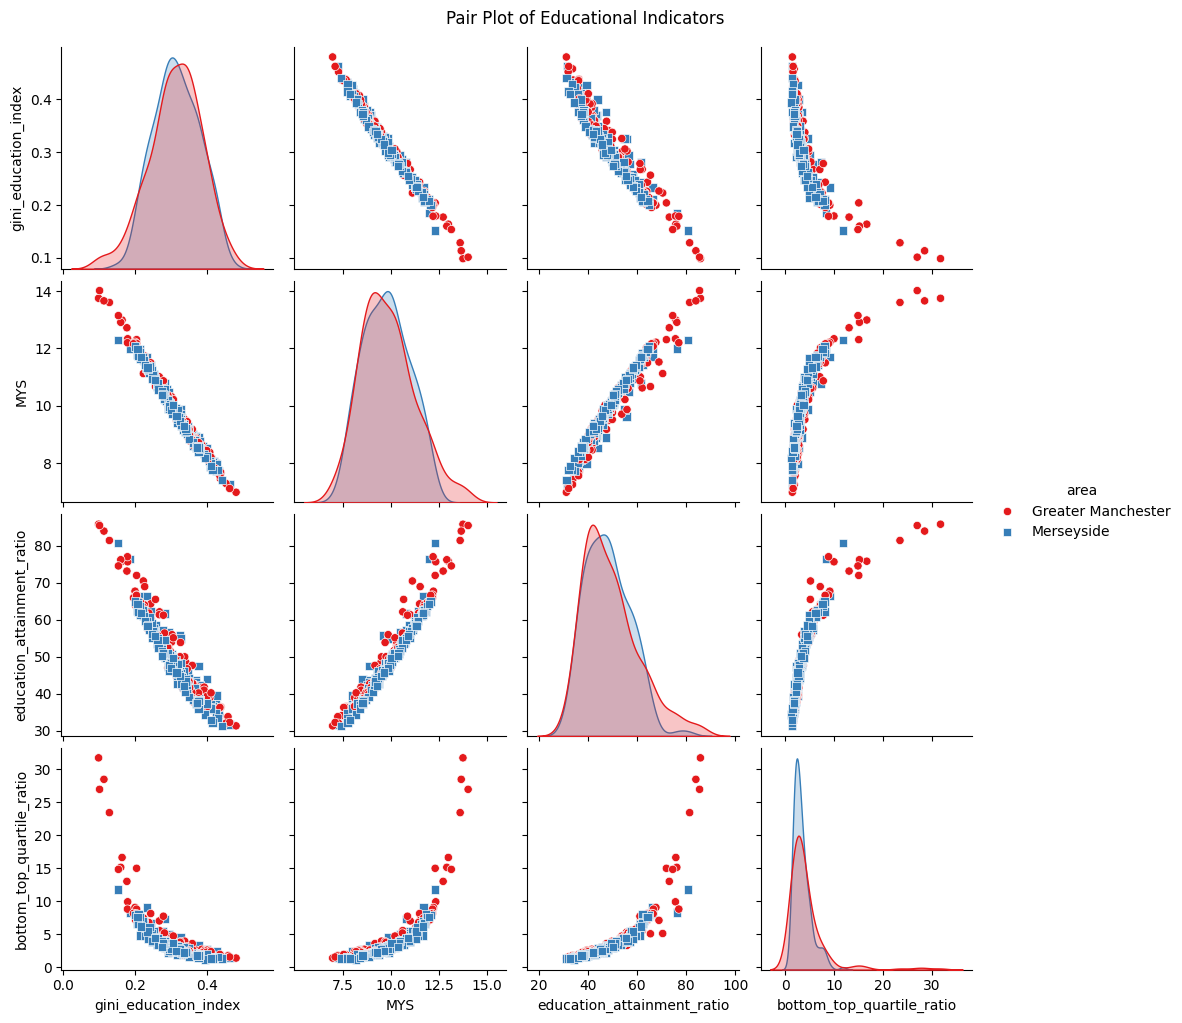

In [52]:
# Select the columns of interest
cols = ['gini_education_index', 'MYS', 'education_attainment_ratio', 'bottom_top_quartile_ratio','area']

# Drop rows with missing values (if any) in these columns
data = merged_df[cols].dropna()

# Create a pair plot
sns.pairplot(data, hue="area", diag_kind="kde", palette="Set1", markers=["o", "s"])
plt.suptitle("Pair Plot of Educational Indicators", y=1.02)  # Adjust title position
plt.savefig('edu.pdf',format='pdf')
plt.show()